### load

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import time
import pandas as pd
from IPython.display import display
from utils import nba_inference_utils as niu
import matplotlib.pyplot as plt
import joblib 
import pprint as pp
from datetime import datetime
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
# create pretty printer
pp = pp.PrettyPrinter(indent=4)
import warnings
warnings.simplefilter(action='ignore')

train_cols = ['Opp_Elo', 'Opp_Momentum', 'SPREAD_LINE_MOVEMENT_1', 
              'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3', 
                'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2',
                'TOTAL_LINE_MOVEMENT_3', 'CREW', 'Opp_Avg_3_game_DEFF',
                'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF',
                'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF',
                'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE',
                'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE',
                'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS',
                'Opp_Season_Avg_POSS', 'Avg_3_game_DEFF',
                'Avg_5_game_DEFF', 'Season_Avg_DEFF',
                'Avg_3_game_OEFF', 'Avg_5_game_OEFF',
                'Season_Avg_OEFF', 'Avg_3_game_PACE',
                'Avg_5_game_PACE', 'Season_Avg_PACE',
                'Avg_3_game_POSS', 'Avg_5_game_POSS',
                'Season_Avg_POSS', 'Avg_3_game_OR', 'Avg_5_game_OR',
                'Season_Avg_OR','Avg_3_game_3P', 'Avg_5_game_3P',
                'Season_Avg_3P','Avg_3_game_3PA', 'Avg_5_game_3PA',
                'Season_Avg_3PA','Avg_3_game_TO', 'Avg_5_game_TO',
                'Season_Avg_TO','Avg_3_game_FT', 'Avg_5_game_FT',
                'Season_Avg_FT','CLOSING_SPREAD',
                'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS',
                'Avg_5_game_PTS', 'Season_Avg_PTS', 'Last_ML_1',
                'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent',
                'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL',
                'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME',
                'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS',
                'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
                'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS',
                    'Offensive_Rating', 'Defensive_Rating',
              'Opp_Offensive_Rating', 'Opp_Defensive_Rating', 'two_week_totals', 'Elo_Var', 'Opp_Elo_Var']

today_map_features = ['TEAM', 'Opponent', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'Venue', 'Referee', 
           'ELO_Rating', 'Momentum',
             'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL',
             'Opp_Elo', 'Opp_Momentum', 'CREW',
              'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME',
              'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS',
              'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
              'SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3',
              'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3',  'Offensive_Rating', 'Defensive_Rating',
              'Opp_Offensive_Rating', 'Opp_Defensive_Rating', 'Elo_Var', 'Opp_Elo_Var']
# allow notebook to reload external modules

DATA_ROOT = '../live_data'
MODEL_ROOT = '../models'


In [19]:
today = datetime.today().strftime('%Y-%m-%d')
total_model = joblib.load(f'calibrated_total_model_exp_2025-03-15_sig.pkl')
ml_model = joblib.load(f'calibrated_ml_model_2025-01-31_sig.pkl')
spread_model = joblib.load(f'calibrated_spread_model_2025-01-31_sig.pkl')

### today's features
- refs
- lines + movement
- today's games

In [8]:
current_odds = niu.scrape_odds()
ref_data = pd.read_csv('../historical_data/2024-2025.csv')

driver = niu.init_driver()
driver.get('https://official.nba.com/referee-assignments/')
time.sleep(5)
html_content = driver.page_source
driver.quit()


referee_data = niu.parse_referee_data(html_content)
for city, refs in referee_data.items():
    if city == 'L.A. Lakers':
        city = 'LA Lakers'
    try:
        current_odds[city][0] = ' '.join(refs[0].split(' ')[:-1])
        current_odds[city][-2] = ' '.join(refs[1].split(' ')[:-1])
        current_odds[city][-1] = ' '.join(refs[2].split(' ')[:-1])
    except KeyError:
        pass  # Handle any missing teams gracefully

#print(current_odds)
TODAY_MAP = niu.remove_ref_keys(current_odds)
TODAY_MAP = pd.DataFrame.from_dict(TODAY_MAP, orient='index', columns=[
    'Referee', 'MONEYLINE', 'Venue', 'Opponent', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'Spread_Movement', 'Total_Movement', 'CREW', 'CREW2'
])

today_teams_list = list(niu.team_map.values())
TODAY_MAP['TEAM'] = TODAY_MAP.index.copy(deep=True)
TODAY_MAP = TODAY_MAP.reset_index(drop=True)
TODAY_MAP = TODAY_MAP.merge(ref_data.groupby('REFEREE').first(), how='left', left_on='Referee', right_on='REFEREE', suffixes=['x', ''])
TODAY_MAP[['TEAM', 'Opponent', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL']]

scraping data for 2025-03-15


,TEAM,Opponent,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL
0,Brooklyn,Boston,380,10.5,215.0
1,Boston,Brooklyn,-500,-10.5,215.0
2,Detroit,Oklahoma City,154,4.5,233.5
3,Oklahoma City,Detroit,-185,-4.5,233.5
4,Houston,Chicago,-340,-8.0,229.5
5,Chicago,Houston,270,8.0,229.5
6,Milwaukee,Indiana,-162,-3.5,235.0
7,Indiana,Milwaukee,136,3.5,235.0
8,Memphis,Miami,-270,-7.0,225.5
9,Miami,Memphis,220,7.0,225.5


### most recent rows from historical dataset
- ELO scores
- Momentum scores


In [22]:
from datetime import datetime
#today = datetime.now().strftime('%Y-%m-%d')
historical_data = pd.DataFrame()
i = 0
while historical_data.empty:
    yesterday = (datetime.now() - pd.DateOffset(i)).strftime('%Y-%m-%d')
    try:
        historical_data = pd.read_csv(f'{DATA_ROOT}/2024_2025_nba_team_exp_{yesterday}.csv')
        print(f'worked with date: {yesterday}')
    except FileNotFoundError:
        i += 1
        pass
#historical_data = pd.read_csv(f'2024_2025_nba_team_full_{yesterday}.csv')
most_recent_historical = niu.get_most_recent_rows(historical_data, today_teams_list)
most_recent_historical[['TEAM', 'DATE', 'Elo_Rating', 'Momentum']]

worked with date: 2025-03-15


,TEAM,DATE,Elo_Rating,Momentum
16028,Atlanta,2025-03-14,1505.881520,38.231696
16020,Brooklyn,2025-03-13,1499.433082,45.932685
16024,Boston,2025-03-14,1504.744964,37.723918
16036,Charlotte,2025-03-14,1494.970669,27.884416
16021,Chicago,2025-03-13,1494.142404,45.592375
16032,Cleveland,2025-03-14,1505.085935,54.038672
16030,Dallas,2025-03-14,1483.569784,49.426835
16038,Denver,2025-03-14,1503.453319,93.311797
16016,Detroit,2025-03-13,1502.358365,39.565235
16022,Golden State,2025-03-13,1502.398204,57.345834


In [29]:
most_recent_historical[['ema3_allowed_or', 'Opp_Ema3_game_TO', 'Ema3_game_FT', 'Opp_Ema3_allowed_3P', 'Ema3_game_TO']]

,ema3_allowed_or,Opp_Ema3_game_TO,Ema3_game_FT,Opp_Ema3_allowed_3P,Ema3_game_TO
16028,9.690217,13.216641,24.433884,13.743745,13.543009
16020,12.342289,14.957024,13.611320,11.468752,10.684625
16024,11.825000,11.468500,12.992779,12.581756,11.200106
16036,11.499807,12.959185,17.159128,14.182552,15.942173
16021,8.150417,10.684625,16.024944,12.822239,14.957024
16032,10.279341,10.917544,22.282400,14.460060,13.795104
16030,11.923797,12.600536,16.959496,10.003679,13.182284
16038,11.705641,13.655080,15.907122,15.898366,10.283088
16016,10.903645,11.887966,17.054879,14.944613,13.450914
16022,13.254258,12.404512,23.568365,16.906673,16.101039


### yesterday's data to update internal features
- running averages
- update ELO + momentum

In [23]:
yesterday_data = niu.download_current_data()
yesterday_df = pd.read_excel(yesterday_data)

# replace all white spaces in column names with _
yesterday_df.columns = yesterday_df.columns.str.replace(' ', '_')

# replace \n in column names with _
yesterday_df.columns = yesterday_df.columns.str.replace('\n', '_')
yesterday_df.columns = yesterday_df.columns.str.replace('__', '_')

yesterday_df['DATE'] = pd.to_datetime(yesterday_df['DATE'])
most_recent_historical_date = most_recent_historical['DATE'].max()

yesterday_df['Opponent'] = yesterday_df.groupby('GAME-ID')['TEAM'].shift(-1) \
.fillna(yesterday_df.groupby('GAME-ID')['TEAM'].shift())

yesterday_df = yesterday_df.groupby('GAME-ID').apply(niu.assign_results)
yesterday_df = yesterday_df.sort_values('DATE')
yesterday_df = yesterday_df.set_index('DATE')
yesterday_df['two_week_totals'] = (
    yesterday_df['total_result']
    .rolling('14D')
    .mean()
)

yesterday_df['one_week_totals'] = (
    yesterday_df['total_result']
    .rolling('7D')
    .mean()
)
yesterday_df.reset_index(inplace=True)
just_yesterday_df = yesterday_df[yesterday_df['DATE'] >= most_recent_historical_date]



yesterday_df[['DATE', 'TEAM', 'Opponent', 'PTS', 'GAME-ID']].tail()

../live_data/03-14-2025-nba-season-team-feed.xlsx


,DATE,TEAM,Opponent,PTS,GAME-ID
1989,2025-03-14,Philadelphia,Indiana,100,22400959
1990,2025-03-14,Indiana,Philadelphia,112,22400959
1991,2025-03-14,Miami,Boston,91,22400958
1992,2025-03-14,Cleveland,Memphis,133,22400962
1993,2025-03-14,Phoenix,Sacramento,122,22400967


### Use most recent historical data as starting point to update ELO / Momentum

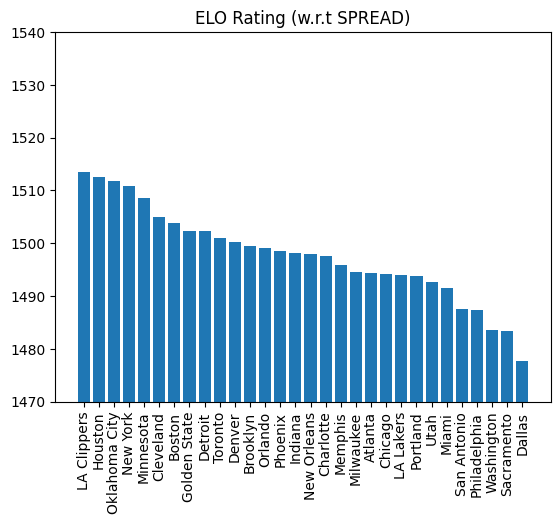

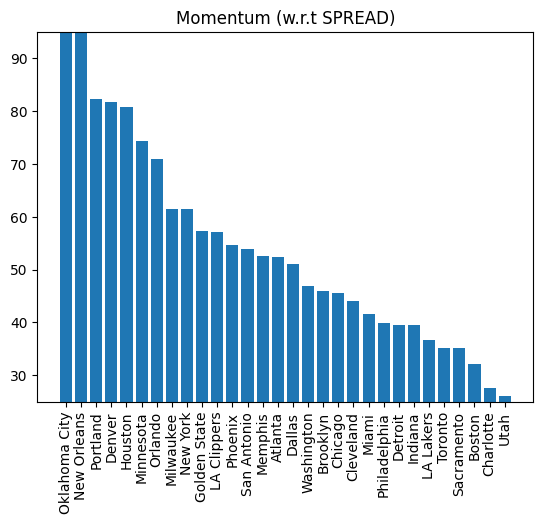

In [24]:
# most recent elo ratings and momentum scores from historical data
elo_ratings = most_recent_historical.set_index('TEAM')['Elo_Rating'].to_dict()
variances = most_recent_historical.set_index('TEAM')['Elo_Var'].to_dict()
momentum_scores = most_recent_historical.set_index('TEAM')['Momentum'].to_dict()

# elo ratings is a dict of team names to elo ratings, and variances is a dict of team names to elo variances
# combine them into a single dict with team as key, mu as elo rating, and sigma as elo variance
team_strengths = {team: {'mu': elo_ratings[team], 'sigma2': variances[team]} for team in elo_ratings}

# Iterate over the new data to update Elo and Momentum
for index, row in just_yesterday_df.iterrows():
    team_elo, _, team_momentum, opp_elo, _, opp_momentum = niu.update_bayesian_elo_momentum(row, just_yesterday_df, team_strengths, momentum_scores)
    # Update the dictionaries with the new Elo and momentum values
    elo_ratings[row['TEAM']] = team_elo
    momentum_scores[row['TEAM']] = team_momentum
    elo_ratings[row['Opponent']] = opp_elo
    momentum_scores[row['Opponent']] = opp_momentum
    variances[row['TEAM']] = team_strengths[row['TEAM']]['sigma2']
    variances[row['Opponent']] = team_strengths[row['Opponent']]['sigma2']

# sort elo ratings and plot on a bar chart
sorted_elo = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_elo)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(1470, 1540)
plt.title("ELO Rating (w.r.t SPREAD)")
plt.show()
# pp.pprint(elo_ratings)
# print()
# print("Updated Momentum Scores:")
# pp.pprint( momentum_scores)
sorted_momentum = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_momentum)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(25, 95)
plt.title("Momentum (w.r.t SPREAD)")
plt.show()


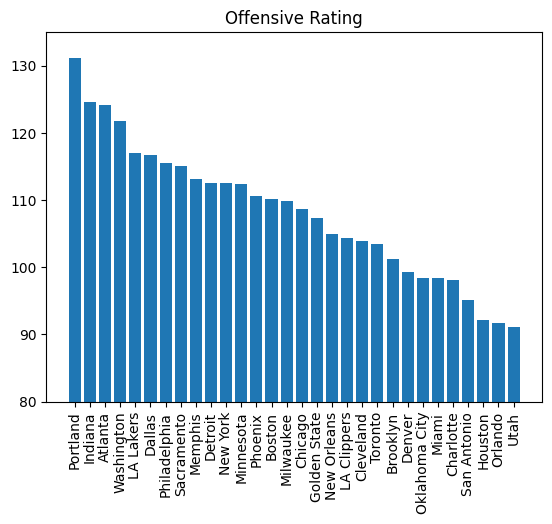

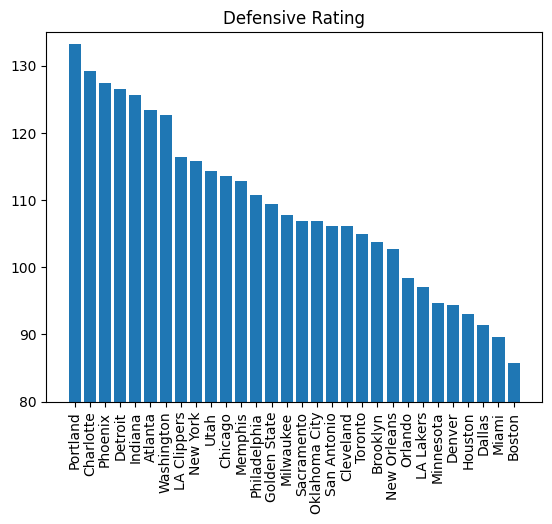

In [25]:
# most recent elo ratings and momentum scores from historical data
off_ratings = most_recent_historical.set_index('TEAM')['Offensive_Rating'].to_dict()
def_ratings = most_recent_historical.set_index('TEAM')['Defensive_Rating'].to_dict()
off_variances = most_recent_historical.set_index('TEAM')['Offensive_Var'].to_dict()
def_variances = most_recent_historical.set_index('TEAM')['Defensive_Var'].to_dict()
momentum_scores = most_recent_historical.set_index('TEAM')['Momentum'].to_dict()

# elo ratings is a dict of team names to elo ratings, and variances is a dict of team names to elo variances
# combine them into a single dict with team as key, mu as elo rating, and sigma as elo variance
team_strengths2 = {team: {'offense': {'mu': off_ratings[team], 'sigma2': off_variances[team]}, 
                         'defense': {'mu': def_ratings[team], 'sigma2': def_variances[team]}} for team in elo_ratings}

# Iterate over the new data to update Elo and Momentum
for index, row in just_yesterday_df.iterrows():
    team_elo, team_elo_d, team_momentum, opp_elo, opp_elo_d, opp_momentum = niu.update_bayesian_off_def(row, just_yesterday_df, team_strengths2, momentum_scores)
    # Update the dictionaries with the new Elo and momentum values
    try:
        team_strengths2[row['TEAM']]['mu'] = team_elo['mu']
        team_strengths2[row['TEAM']]['mu'] = team_elo_d['mu']
        team_strengths2[row['TEAM']]['sigma2'] = team_elo['sigma2']
        momentum_scores[row['TEAM']] = team_momentum
        team_strengths2[row['Opponent']]['mu'] = opp_elo['mu']
        team_strengths2[row['Opponent']]['mu'] = opp_elo_d['mu']
        team_strengths2[row['Opponent']]['sigma2'] = opp_elo['sigma2']
        momentum_scores[row['Opponent']] = opp_momentum
    except Exception as e:
        print(e)
        pass

# Output the updated Elo ratings and momentum scores
#print("Updated Offensive Ratings:", off_ratings)
sorted_off = sorted(off_ratings.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_off)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(80, 135)
plt.title("Offensive Rating")
plt.show()

sorted_def = sorted(def_ratings.items(), key=lambda x: x[1], reverse=True)
teams, ratings = zip(*sorted_def)
plt.bar(teams, ratings)
plt.xticks(rotation=90)
plt.ylim(80, 135)
plt.title("Defensive Rating")
plt.show()
#print("Updated Defensive Ratings:", def_ratings)
#print("Updated Momentum Scores:", momentum_scores)


### Update TODAY_MAP with new elo/momentum (opps too)

In [26]:
# convert index to TEAM column in TODAY_MAP

TODAY_MAP['ELO_Rating'] = TODAY_MAP['TEAM'].map(elo_ratings)
TODAY_MAP['Offensive_Rating'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['offense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Defensive_Rating'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['defense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Offensive_Var'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['offense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Defensive_Var'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['defense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Offensive_Var'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['offense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Defensive_Var'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['defense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Momentum'] = TODAY_MAP['TEAM'].map(momentum_scores)
TODAY_MAP['Opp_Elo'] = TODAY_MAP['Opponent'].map(elo_ratings)
TODAY_MAP['Elo_Var'] = TODAY_MAP['TEAM'].map(variances) 
TODAY_MAP['Opp_Elo_Var'] = TODAY_MAP['Opponent'].map(variances)
TODAY_MAP['Opp_Offensive_Rating'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['offense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Defensive_Rating'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['defense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP[['SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3']] = pd.DataFrame(TODAY_MAP['Spread_Movement'].to_list(), index=TODAY_MAP.index)
TODAY_MAP[['TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3']] = pd.DataFrame(TODAY_MAP['Total_Movement'].to_list(), index=TODAY_MAP.index)
TODAY_MAP[['OPP_SPREAD_MOVEMENT_1', 'OPP_SPREAD_MOVEMENT_2', 'OPP_SPREAD_MOVEMENT_3']] = TODAY_MAP['Opponent'].map(TODAY_MAP.set_index('TEAM')[['SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3']].to_dict('index')).apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))
TODAY_MAP[['OPP_TOTAL_MOVEMENT_1', 'OPP_TOTAL_MOVEMENT_2', 'OPP_TOTAL_MOVEMENT_3']] = TODAY_MAP['Opponent'].map(TODAY_MAP.set_index('TEAM')[['TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3']].to_dict('index')).apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))

TODAY_MAP['Opp_Momentum'] = TODAY_MAP['Opponent'].map(momentum_scores)
TODAY_MAP[['TEAM', 'Opponent', 'Offensive_Rating', 'Defensive_Rating', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'ELO_Rating', 'Opp_Elo', 'Momentum', 'Opp_Momentum', ]]



,TEAM,Opponent,Offensive_Rating,Defensive_Rating,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL,ELO_Rating,Opp_Elo,Momentum,Opp_Momentum
0,Brooklyn,Boston,101.242811,103.767921,380,10.5,215.0,1499.433082,1503.893977,45.932685,31.976339
1,Boston,Brooklyn,111.292001,85.301463,-500,-10.5,215.0,1503.893977,1499.433082,31.976339,45.932685
2,Detroit,Oklahoma City,112.598883,126.556949,154,4.5,233.5,1502.358365,1511.848633,39.565235,108.270666
3,Oklahoma City,Detroit,98.445497,106.823236,-185,-4.5,233.5,1511.848633,1502.358365,108.270666,39.565235
4,Houston,Chicago,107.401952,89.796213,-340,-8.0,229.5,1512.578187,1494.142404,92.475200,45.592375
5,Chicago,Houston,108.634028,113.576496,270,8.0,229.5,1494.142404,1512.578187,45.592375,92.475200
6,Milwaukee,Indiana,109.907119,107.812170,-162,-3.5,235.0,1494.585468,1498.124146,61.543132,51.421545
7,Indiana,Milwaukee,122.549713,118.006685,136,3.5,235.0,1498.124146,1494.585468,51.421545,61.543132
8,Memphis,Miami,118.481456,121.932434,-270,-7.0,225.5,1495.914440,1491.603246,79.796658,41.532111
9,Miami,Memphis,98.026140,90.834250,220,7.0,225.5,1491.603246,1495.914440,41.532111,79.796658


In [27]:
t_features = list(total_model.feature_names_in_)
s_features = list(spread_model.feature_names_in_)
ml_features = list(ml_model.feature_names_in_)
#s_inf_features = list(spread_model.feature_names_in_)

### update rolling stats, collect features, and perform inference

In [33]:
# get all the rolling stats for today
most_recent_tdf = niu.get_rolling_stats(yesterday_df, today_teams_list)
today_features = TODAY_MAP[today_map_features + ['Offensive_Var', 'Defensive_Var', 'Opp_Offensive_Var', 'Opp_Defensive_Var']]

# merge most_recent_tdf with today_features on TEAM
infer_df = most_recent_tdf.merge(today_features, how='left', on='TEAM')
infer_df = infer_df.merge(most_recent_historical[['TEAM', 'ema3_allowed_or', 'Opp_Ema3_game_TO', 'Ema3_game_FT', 'Opp_Ema3_allowed_3P', 'Ema3_game_TO']], how='left', on='TEAM')

# convert categorical columns
infer_df['MAIN REF'] = infer_df['Referee'].astype('category')
infer_df['TEAM'] = infer_df['TEAM'].astype('category')
infer_df['CREW'] = infer_df['CREW'].astype('category')
infer_df['Opponent'] = infer_df['Opponent_y'].astype('category')
infer_df['TEAM_REST_DAYS'] = infer_df['TEAM_REST_DAYS'].astype('category')

# fix merged column names
infer_df['MONEYLINE'] = infer_df['MONEYLINE_y']
infer_df['VENUE'] = infer_df['Venue']
infer_df['CLOSING_SPREAD'] = infer_df['CLOSING_SPREAD_y']
infer_df['CLOSING_TOTAL'] = infer_df['CLOSING_TOTAL_y']
infer_df['Elo_Rating'] = infer_df['ELO_Rating']
# convert datatypes
infer_df['VENUE'] = (infer_df['VENUE'] == 'H')*1
infer_df[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]] = (
        infer_df[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]]
        .replace('even', '-100', regex=True)
        .fillna(0)
        .astype(int)
    )
temp_df = infer_df.dropna(subset=['TEAM', 'Opponent'])
temp_df[['TEAM', 'Opponent']].dropna()

# filter down to train cols
#infer_df = infer_df[train_cols +['DATE', 'GAME-ID', 'Offensive_Var', 'Defensive_Var', 'Opp_Offensive_Var', 'Opp_Defensive_Var', 'one_week_totals']]
#infer_df = infer_df[inf_features]
# s_infer_df = infer_df[s_inf_features]
# Get predictions from the ensemble models
infer_df = infer_df.sort_values(by='DATE')
infer_df = infer_df.drop_duplicates(subset=['TEAM'], keep='last')
infer_df.dropna(subset=['TEAM', 'Opponent'], inplace=True)
spread_probabilities = spread_model.predict_proba(infer_df[s_features])[:, 1]
total_probabilities = total_model.predict_proba(infer_df[t_features])[:, 1]
ml_probabilities = ml_model.predict_proba(infer_df[ml_features])[:, 1]


real_probabilities = {}
processed_games = set()


ps = {team: prob for team, prob in zip(infer_df['TEAM'], total_probabilities)}
for team, opp in zip(infer_df['TEAM'], infer_df['Opponent']):
    # Ensure we process each game only once
    game = tuple(sorted([team, opp]))
    if game not in processed_games:
        processed_games.add(game)
        # Sum probabilities of both teams and divide by 2
        prob_team = ps[team]
        prob_opp = ps[opp]
        average_prob = (prob_team + prob_opp) / 2
        # Assign the average probability to both teams
        real_probabilities[team] = average_prob
        real_probabilities[opp] = average_prob
    else:
        # If the game is already processed, assign the existing average probability
        average_prob = real_probabilities[team]
        
# Update the probabilities mapping with the averaged probabilities
ps = real_probabilities
spread_predictions = np.array([x > 0.5 for x in spread_probabilities])
ml_predictions = np.array([x > 0.5 for x in ml_probabilities])
total_predictions = np.array([x > 0.5 for x in total_probabilities])

infer_df['spread_prob'] = spread_probabilities
infer_df['ml_prob'] = ml_probabilities
infer_df['total_prob'] = total_probabilities

# get the results
today_results = infer_df[['TEAM', 'Opponent', 'MONEYLINE',
                        'CLOSING_SPREAD', 'CLOSING_TOTAL',
                        'spread_prob', 'ml_prob', 'total_prob']].dropna().reset_index(drop=True)

spread_ps = {team: prob for team, prob in zip(today_results['TEAM'].values, spread_probabilities)}
normed_spread_odds = {team: spread_ps[team]/(spread_ps[team] + spread_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}
ml_ps = {team: prob for team, prob in zip(today_results['TEAM'].values, ml_probabilities)}
normed_ml_odds = {team: ml_ps[team]/(ml_ps[team] + ml_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}
total_ps = ps #{team: prob for team, prob in zip(today_results['TEAM'].values, total_probabilities)}
normed_total_odds = ps #{team: total_ps[team]/(total_ps[team] + total_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}

today_results['spread_prob_normed'] = today_results['TEAM'].map(normed_spread_odds)
today_results['ml_prob_normed'] = today_results['TEAM'].map(normed_ml_odds)
today_results['total_prob_normed'] = today_results['TEAM'].map(normed_total_odds)
today_results['total_prob'] = today_results['TEAM'].map(normed_total_odds)

In [40]:
BR = 500
unit = BR/2

# convert CLOSING_SPREAD to implied probability
today_results['CLOSING_SPREAD_LINE'] = -110
today_results['CLOSING_TOTAL_LINE'] = -110
today_results['spread_implied_prob'] = today_results['CLOSING_SPREAD_LINE'].apply(niu.odds_to_implied_prob)
today_results['total_implied_prob'] = today_results['CLOSING_TOTAL_LINE'].apply(niu.odds_to_implied_prob)
today_results['total_implied_prob'] = today_results['MONEYLINE'].apply(niu.odds_to_implied_prob)
# add column to today_results for kelly criterion
today_results['spread_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['spread_prob_normed'], -110, temper=0.5), axis=1)
today_results['total_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['total_prob_normed'], -110, temper=0.5), axis=1)
today_results['ml_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['ml_prob_normed'], -110, temper=0.5), axis=1)


### TOTALS

In [41]:


print('PREDICTED OVERS')
over_df = today_results[(today_results['total_prob'] > 0.5)]
over_df["sorted_pair"] = over_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
over_df = over_df.drop_duplicates(subset="sorted_pair", keep="first")

total_frame = today_results.drop_duplicates(subset=['TEAM'])
display(over_df[(total_frame['total_prob'] > 0.5)] \
.sort_values('total_prob', ascending=False)[['TEAM', 'Opponent','CLOSING_TOTAL',
                                                'total_prob', 'total_kelly']])
under_df = total_frame[(total_frame['total_prob'] <= 0.5)]
under_df['total_prob'] = 1 - under_df['total_prob']
under_df["sorted_pair"] = under_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
under_df = under_df.drop_duplicates(subset="sorted_pair", keep="first")
under_df['total_kelly'] = under_df.apply(lambda x: niu.kelly_criterion(unit, x['total_prob'], -110, temper=0.5), axis=1)
print('\nPREDICTED UNDERS\n')
display(under_df \
.sort_values('total_prob', ascending=False)[['TEAM', 'Opponent','CLOSING_TOTAL',
                                                'total_prob', 'total_kelly']])

PREDICTED OVERS


,TEAM,Opponent,CLOSING_TOTAL,total_prob,total_kelly
9,Miami,Memphis,225.5,0.589978,17.369118
0,New York,Golden State,228.5,0.580498,14.880642
1,Oklahoma City,Detroit,233.5,0.572225,12.709056
5,Chicago,Houston,229.5,0.570331,12.211780
2,Milwaukee,Indiana,235.0,0.523189,-0.162827
6,Brooklyn,Boston,215.0,0.504813,-4.986713



PREDICTED UNDERS



,TEAM,Opponent,CLOSING_TOTAL,total_prob,total_kelly
3,New Orleans,San Antonio,235.5,0.535178,2.984309
8,Washington,Denver,241.0,0.523133,-0.177538


### MONEYLINE

In [42]:
today_results[today_results['ml_kelly'] > 0][['TEAM', 'Opponent','MONEYLINE','ml_prob_normed', 'ml_kelly']].sort_values('ml_prob_normed', ascending=False)

,TEAM,Opponent,MONEYLINE,ml_prob_normed,ml_kelly
9,Miami,Memphis,220,0.588526,16.988143
3,New Orleans,San Antonio,-135,0.549890,6.846086
14,Boston,Brooklyn,-500,0.537034,3.471499
5,Chicago,Houston,270,0.532014,2.153711
8,Washington,Denver,500,0.529862,1.588830


### SPREAD

In [43]:
today_results[today_results['spread_kelly'] > 0][['TEAM', 'Opponent','spread_prob_normed', 'spread_kelly']].sort_values('spread_prob_normed', ascending=False)

,TEAM,Opponent,spread_prob_normed,spread_kelly
15,Memphis,Miami,0.998427,124.587209
14,Boston,Brooklyn,0.993319,123.246248
3,New Orleans,San Antonio,0.990355,122.468225
13,Denver,Washington,0.989287,122.187839
5,Chicago,Houston,0.778083,66.746886
2,Milwaukee,Indiana,0.757248,61.277624
1,Oklahoma City,Detroit,0.648371,32.697385
4,Golden State,New York,0.603313,20.869739


### EXTRAS

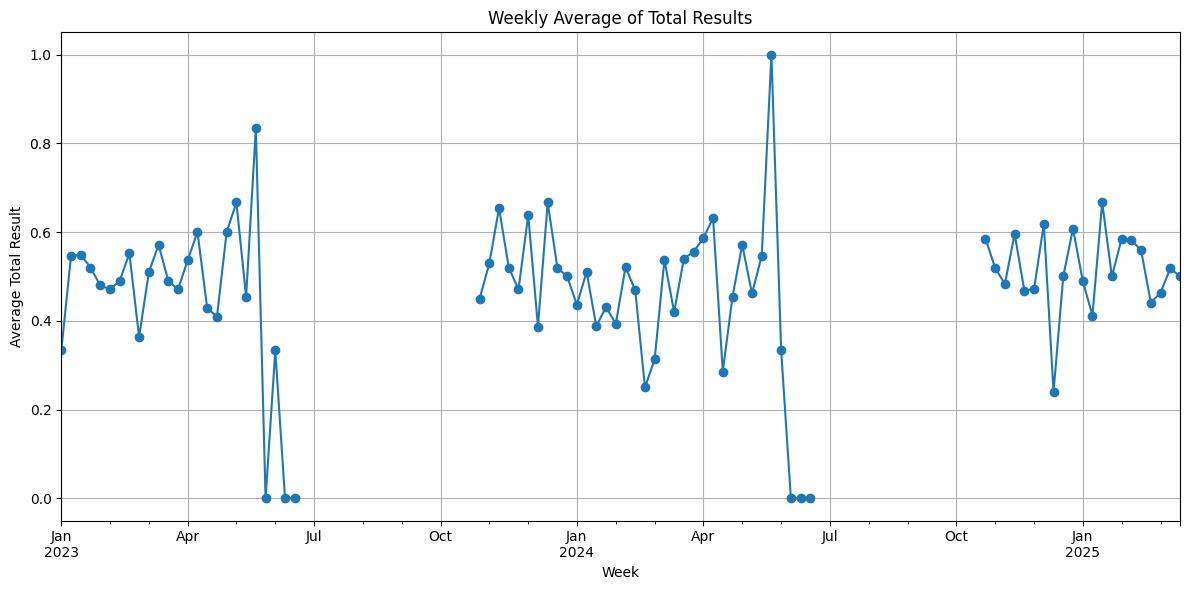

In [44]:
# Ensure 'DATE' is in datetime format
historical_data['DATE'] = pd.to_datetime(historical_data['DATE'])

this_year_data = historical_data[historical_data['DATE'].dt.year >= 2023]
# Convert 'total_result' to integer
this_year_data['total_result'] = historical_data['total_result'].astype(int)

#list of freq values
#freq_values = ['D', 'W', 'M', 'Q', 'Y']
# Group by week using Grouper and calculate the mean
weekly_data = this_year_data.groupby(pd.Grouper(key='DATE', freq='W'))['total_result'].mean()

# Plot the weekly average of 'total_result'
plt.figure(figsize=(12, 6))
weekly_data.plot(marker='o', linestyle='-')
plt.title('Weekly Average of Total Results')
plt.xlabel('Week')
plt.ylabel('Average Total Result')
plt.grid(True)
plt.tight_layout()
plt.show()


### COMPLETE

In [45]:
player_df = pd.read_csv(f'{DATA_ROOT}/nba_players_data_011925.csv')

player_features = [col for col in player_df.columns if col not in ['DATE', 'PLAYER_FULL_NAME','DR',
 'TOT',
 'PF',
 'ST',
 'TO',
 'BL', 'PTS', 'PTS_target', 'A_target', 'R_target']]

In [46]:
pts_model = joblib.load(f'players_model_exp_2025-03-15_sig.pkl')
a_model = joblib.load(f'{MODEL_ROOT}/a_model.pkl')
r_model = joblib.load(f'{MODEL_ROOT}/r_model.pkl')

In [47]:
yesterday_file = niu.download_current_players_data()
today_data = pd.read_excel(yesterday_file)
d6 = pd.read_excel(f'{DATA_ROOT}/NBA-2023-2024-Player-BoxScore-Dataset.xlsx')
infer_df = pd.concat([d6, today_data])
# replace all white spaces in column names with _
infer_df.columns = infer_df.columns.str.replace(' ', '_')

# replace \n in column names with _
infer_df.columns = infer_df.columns.str.replace('\n', '_')
infer_df.columns = infer_df.columns.str.replace('__', '_')

# more cleanup and data preprocessing
#df = df.dropna()
#df = df.drop_duplicates()
infer_df = infer_df.reset_index(drop=True)

# convert dates to datetime and sort by date
infer_df['DATE'] = pd.to_datetime(infer_df['DATE'])
infer_df['R'] = infer_df['OR'] + infer_df['DR']

../live_data/03-14-2025-nba-season-player-feed.xlsx
200


In [48]:
# Ensure the DataFrame is sorted by 'PLAYER-ID' and 'DATE' so we get the latest record
infer_df = infer_df.sort_values(by=['PLAYER-ID', 'DATE'])

# Filter to keep only the most recent row for each player
recent_infer_df = infer_df.loc[infer_df.groupby('PLAYER-ID')['DATE'].idxmax()].reset_index(drop=True)

# Group by GAME-ID, OPPONENT_TEAM, and POSITION to calculate the total points given up in each game
points_given_up = recent_infer_df.groupby(['GAME-ID', 'OPPONENT_TEAM', 'OWN_TEAM', 'POSITION'])['PTS'].sum().reset_index()
points_given_up.rename(columns={'PTS': 'PTS_Allowed'}, inplace=True)

# Sort by OPPONENT_TEAM and GAME-ID to prepare for rolling calculations
points_given_up.sort_values(by=['OPPONENT_TEAM', 'GAME-ID'], inplace=True)

# Calculate the rolling average of the last 3 games for each team and position
points_given_up['Rolling_Avg_Last_3'] = (
    points_given_up.groupby(['OPPONENT_TEAM', 'POSITION'])['PTS_Allowed']
    .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
)

# Pivot the table to convert rows for each position into columns, using OWN_TEAM for the matchup
points_given_up_pivot = points_given_up.pivot(index=['GAME-ID', 'OWN_TEAM'], columns='POSITION', values=['Rolling_Avg_Last_3'])

# Flatten the column multi-index created by pivot for easier access
points_given_up_pivot.columns = [f'{stat}_{pos}' for stat, pos in points_given_up_pivot.columns]

# Reset the index to make GAME-ID and OWN_TEAM columns again
points_given_up_pivot.reset_index(inplace=True)

# Forward fill NaNs to ensure rolling averages are consistent
points_given_up_pivot.ffill(inplace=True)

# Display the pivoted result for verification
display(points_given_up_pivot.tail())


,GAME-ID,OWN_TEAM,Rolling_Avg_Last_3_C,Rolling_Avg_Last_3_C-F,Rolling_Avg_Last_3_F,Rolling_Avg_Last_3_F-C,Rolling_Avg_Last_3_F-G,Rolling_Avg_Last_3_G,Rolling_Avg_Last_3_G-F
302,42300302,Indiana,2.666667,10.5,9.8,12.666667,0.0,24.4,1.0
303,52300111,Atlanta,2.666667,10.5,9.8,12.666667,0.0,7.0,1.0
304,52300131,Golden State,2.666667,10.5,26.8,12.666667,0.0,7.0,1.0
305,52300131,Sacramento,2.666667,2.0,26.8,12.666667,0.0,7.0,1.0
306,52300211,Sacramento,2.666667,2.0,4.0,12.666667,0.0,7.0,1.0


In [49]:
# Select only the rolling average columns and the index columns for merging
rolling_avg_columns = ['GAME-ID', 'OWN_TEAM'] + [col for col in points_given_up_pivot.columns if 'Rolling_Avg_Last_3' in col]
rolling_avg_df = points_given_up_pivot[rolling_avg_columns]

# Merge with the recent inference DataFrame on GAME-ID and OWN_TEAM
infer_df = recent_infer_df.merge(rolling_avg_df, on=['GAME-ID', 'OWN_TEAM'], how='left')

# Filter the DataFrame to include only the desired subset of columns
infer_subset_cols = [
    'GAME-ID', 'PLAYER_FULL_NAME', 'PLAYER-ID', 'DATE', 'PTS', 'USAGE_RATE_(%)', 
    '3P', '3PA', 'FG', 'FGA', 'A', 'R', 'FT', 'FTA', 'OWN_TEAM', 'OPPONENT_TEAM', 
    'MIN', 'DR', 'TOT', 'PF', 'ST', 'TO', 'BL', 'VENUE_(R/H)', 'STARTER_(Y/N)', 'POSITION'
] + [col for col in infer_df.columns if 'Rolling_Avg_Last_3' in col]

infer_df = infer_df[infer_subset_cols]

# Display the resulting DataFrame for verification
display(infer_df.head())


,GAME-ID,PLAYER_FULL_NAME,PLAYER-ID,DATE,PTS,USAGE_RATE_(%),3P,3PA,FG,FGA,...,VENUE_(R/H),STARTER_(Y/N),POSITION,Rolling_Avg_Last_3_C,Rolling_Avg_Last_3_C-F,Rolling_Avg_Last_3_F,Rolling_Avg_Last_3_F-C,Rolling_Avg_Last_3_F-G,Rolling_Avg_Last_3_G,Rolling_Avg_Last_3_G-F
0,22400918,LeBron James,2544,2025-03-08,22,33.499264,0,6,11,23,...,NaN,Y,F,2.000000,4.0,14.500000,3.500000,0.0,3.0,14.5
1,22400964,Chris Paul,101108,2025-03-14,3,11.653880,1,1,1,3,...,NaN,Y,G,0.000000,2.0,15.500000,13.000000,6.0,21.0,17.0
2,22400754,Kyle Lowry,200768,2025-02-09,0,0.000000,0,0,0,0,...,NaN,N,G,0.000000,0.0,2.500000,26.000000,4.0,1.0,5.0
3,42300176,P.J. Tucker,200782,2024-05-03,8,18.105823,2,3,3,5,...,R,Y,F,7.000000,10.5,21.666667,12.666667,0.0,7.6,1.0
4,22400967,Kevin Durant,201142,2025-03-14,22,27.806809,4,6,7,15,...,NaN,Y,F,7.333333,10.5,33.500000,3.000000,37.0,27.4,6.0


In [50]:
# Ensure infer_df is sorted by player and date
infer_df = infer_df.sort_values(by=['PLAYER-ID', 'DATE'])

stats = ['PTS', 'USAGE_RATE_(%)', '3P', '3PA', 'FG', 'FGA', 'A', 'R', 'FT', 'FTA']
# Calculate rolling averages for the last 3 and 5 games
for stat in stats:  # Using the same 'stats' list as before
    infer_df[f'{stat}_3G_avg'] = infer_df.groupby('PLAYER-ID')[stat].transform(lambda x: x.rolling(3, min_periods=1).mean())
    infer_df[f'{stat}_5G_avg'] = infer_df.groupby('PLAYER-ID')[stat].transform(lambda x: x.rolling(5, min_periods=1).mean())


In [51]:

# Select feature columns for inference, excluding target-related columns
X_infer = infer_df[player_features]  # Reusing the `features` list from training setup
X_infer['OWN_TEAM'] = X_infer['OWN_TEAM'].astype('category')
X_infer['OPPONENT_TEAM'] = X_infer['OPPONENT_TEAM'].astype('category')
X_infer['VENUE_(R/H)'] = X_infer['VENUE_(R/H)'].astype('category')
X_infer['STARTER_(Y/N)'] = X_infer['STARTER_(Y/N)'].astype('category')
X_infer['POSITION'] = X_infer['POSITION'].astype('category')
# Run inference on each row
features_in = pts_model.feature_names_in_
recent_infer_df['PTS_pred'] = pts_model.predict(X_infer[features_in])
recent_infer_df['A_pred'] = a_model.predict(X_infer)
recent_infer_df['R_pred'] = r_model.predict(X_infer)


# Display predictions for all unique players
player_predictions = recent_infer_df[['GAME-ID', 'PLAYER-ID', 'PLAYER_FULL_NAME', 'OWN_TEAM', 'OPPONENT_TEAM', 'PTS_pred', 'A_pred', 'R_pred']]



In [52]:
today = datetime.today().strftime('%Y%m%d')
response = requests.get(f'http://stats.nba.com/js/data/leaders/00_daily_lineups_{today}.json')

In [53]:
starters = []
for game in response.json()['games']:
    starters += [p['playerName'] for p in game['homeTeam']['players']]
    starters += [p['playerName'] for p in game['awayTeam']['players']]

len(starters)

80

In [54]:
today_preds = player_predictions[player_predictions['PLAYER_FULL_NAME'].isin(starters)].sort_values(by=['PTS_pred'], ascending=False)

In [55]:


# Set up Chrome options for Selenium
options = Options()
options.add_argument('--headless')  # Run in headless mode to avoid opening the browser window
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Initialize the Selenium WebDriver
driver = webdriver.Chrome(options=options)

# Open the target website
url = 'https://www.scoresandodds.com/nba/props'  # Replace with the actual URL
driver.get(url)

# Wait for the elements to load
time.sleep(5)  # Adjust as needed based on page load time

# Scrape player prop lines
player_data = []

# Locate the prop list by finding all relevant 'li' elements with class 'border'
prop_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.table-list > li.border')

# Loop through each prop element and extract relevant data
for prop in prop_elements:
    player_name = prop.get_attribute('data-name')
    projected_score = prop.get_attribute('data-proj')
    delta = prop.get_attribute('data-delta')
    
    # Fetch odds details for each over/under entry
    odds_entries = prop.find_elements(By.CLASS_NAME, 'best-odds-container')
    
    for odds in odds_entries:
        # Extract over/under line and the associated odds
        line_element = odds.find_element(By.CLASS_NAME, 'data-moneyline')
        odds_element = odds.find_element(By.CLASS_NAME, 'data-odds')
        
        line_text = line_element.text
        odds_text = odds_element.text
        
        # Determine if it's an over or under line based on the line text
        over_under = 'Over' if 'o' in line_text else 'Under'
        line_value = line_text[1:]  # Strip out 'o' or 'u' prefix
        
        # Append to the data list
        player_data.append({
            'Player': player_name,
            'Projected_Score': projected_score,
            'Delta': delta,
            'Line_Type': over_under,
            'Line_Value': line_value,
            'Odds': odds_text
        })

# Close the driver
driver.quit()

# Convert to DataFrame for easier analysis
df = pd.DataFrame(player_data)

# remove duplicate rows based on Player
df = df.drop_duplicates(subset=['Player'])

# Display the resulting DataFrame
df.tail()


,Player,Projected_Score,Delta,Line_Type,Line_Value,Odds
218,mitchell robinson,5.06,-0.44,Over,5.5,even
220,gui santos,3.77,-0.73,Over,4.5,-125
222,ron holland,4.22,-0.28,Over,4.5,even
224,ben sheppard,4.42,-0.08,Over,3.5,-105
226,simone fontecchio,3.46,-0.04,Over,3.5,-125


In [59]:
# Convert player names to lowercase for both DataFrames
df['Player'] = df['Player'].str.lower()
player_predictions['PLAYER_FULL_NAME'] = player_predictions['PLAYER_FULL_NAME'].str.lower()

# Merge on the player name column
merged_df = player_predictions.merge(df, left_on='PLAYER_FULL_NAME', right_on='Player', how='left')

# Drop duplicate 'Player' column if necessary
merged_df.drop(columns=['Player'], inplace=True)

#create delta column between PTS_pred and Line_Value
merged_df['Line_Value'] = merged_df['Line_Value'].astype(float)
merged_df['Delta'] = merged_df['PTS_pred'] - merged_df['Line_Value']
merged_df['Delta2'] = merged_df['Projected_Score'].astype(float) - merged_df['Line_Value']

In [62]:
## PARAMS
min_delta_1 = -1
min_delta_2 = -1
min_over_prob = 0.525
max_under_prob = 1 - min_over_prob


In [63]:
player_cols = ['GAME-ID', 'PLAYER-ID', 'PLAYER_FULL_NAME',
                'OWN_TEAM', 'PTS_pred', 'Projected_Score', 
               'Line_Value', 'Delta', 'Delta2']

t_df = today_results.copy(deep=True)
t_df["sorted_pair"] = t_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
t_df = t_df.drop_duplicates(subset="sorted_pair", keep="first")

for team, opp in zip(t_df.TEAM.unique(), t_df.Opponent.unique()):
    game_preds = t_df[((t_df['TEAM'] == team))]
    if merged_df[merged_df['OWN_TEAM'] == team].dropna().shape[0] > 0:
        plays = merged_df[(merged_df['OWN_TEAM'] == team) &
                           (merged_df['Delta'] > min_delta_1) &
                             (merged_df['Delta2'] > min_delta_2) &
                               (((merged_df['Line_Value'] >= 11) & (merged_df['Line_Value'] <= 15)) |
                                ((merged_df['Line_Value'] >= 16) & (merged_df['Line_Value'] <= 20)) |
                                ((merged_df['Line_Value'] >= 21) & (merged_df['Line_Value'] <= 25)) |
                                ((merged_df['Line_Value'] >= 26) & (merged_df['Line_Value'] <= 30)))]
        opp_plays = merged_df[(merged_df['OWN_TEAM'] == opp) &
                           (merged_df['Delta'] > -1) &
                             (merged_df['Delta2'] > -1) &
                               (((merged_df['Line_Value'] >= 11) & (merged_df['Line_Value'] <= 15)) |
                                ((merged_df['Line_Value'] >= 16) & (merged_df['Line_Value'] <= 20)) |
                                ((merged_df['Line_Value'] >= 21) & (merged_df['Line_Value'] <= 25)) |
                                ((merged_df['Line_Value'] >= 26) & (merged_df['Line_Value'] <= 30)))]
        

        # if we want to play this total
        if game_preds[((game_preds['total_prob'] > min_over_prob) | (game_preds['total_prob'] < max_under_prob))].shape[0] > 0:
          total_side = 'OVER' if game_preds['total_prob'].values[0] > 0.5 else 'UNDER'
          print(f'PLAY {total_side} {game_preds['CLOSING_TOTAL'].values[0]} FOR {team} v. {opp} (p: {game_preds["total_prob"].values[0]:.2f}) for ${game_preds["total_kelly"].values[0]:.0f}')
          if (plays.shape[0] > 0):
            for (name, line_value, delta, delta2) in plays.sort_values(by=['Delta'], ascending=False).dropna()[['PLAYER_FULL_NAME', 'Line_Value', 'Delta', 'Delta2']].values:
              
              # name = player['PLAYER_FULL_NAME']
              # line_value = player['Line_Value']
              # # round line value down to nearest 5
              line_value = 5 * round(line_value/5)
              # delta = player['Delta']
              # delta2 = player['Delta2']
              print(f'\t+ {name} at over {line_value} points (delta 1: {delta: .2f}, delta 2: {delta2: .2f})')
            if opp_plays.shape[0] > 0:
              print("\t" + "-" * 80)
              for (opp_name, opp_line_value, opp_delta, opp_delta2) in opp_plays.sort_values(by=['Delta'], ascending=False).dropna()[['PLAYER_FULL_NAME', 'Line_Value', 'Delta', 'Delta2']].values:
                # opp_name = opp_player['PLAYER_FULL_NAME']
                # opp_line_value = opp_player['Line_Value']
                opp_line_value = 5 * round(opp_line_value/5)
                # opp_delta = opp_player['Delta']
                # opp_delta2 = opp_player['Delta2']
                print(f'\t+ {opp_name} at over {opp_line_value} points (delta 1: {opp_delta: .2f}, delta 2: {opp_delta2: .2f})')
          print(f'')
          print()

PLAY OVER 228.5 FOR New York v. Golden State (p: 0.58) for $15
	+ mikal bridges at over 20 points (delta 1:  19.57, delta 2: -0.58)
	+ karl-anthony towns at over 25 points (delta 1: -0.44, delta 2:  2.59)
	--------------------------------------------------------------------------------
	+ moses moody at over 10 points (delta 1:  5.17, delta 2:  0.97)
	+ jonathan kuminga at over 15 points (delta 1:  2.04, delta 2:  0.71)


PLAY OVER 233.5 FOR Oklahoma City v. Detroit (p: 0.57) for $13
	+ luguentz dort at over 10 points (delta 1:  2.09, delta 2:  1.89)
	--------------------------------------------------------------------------------
	+ cade cunningham at over 25 points (delta 1:  28.68, delta 2:  0.62)
	+ jalen duren at over 10 points (delta 1:  4.41, delta 2:  1.00)
	+ tobias harris at over 15 points (delta 1:  2.37, delta 2:  1.01)


PLAY UNDER 235.5 FOR New Orleans v. San Antonio (p: 0.46) for $-15


PLAY OVER 229.5 FOR Chicago v. Houston (p: 0.57) for $12
	+ tre jones at over 10 poin